# Use Matplotlib to Plot .INV Files from Res2DInv

## Setup

In [ ]:

%matplotlib inline

inDirPath = pathlib.Path("/content/InversionFiles/")
inDir = str(inDirPath) #Set a variable for use throughout the notebook

#Make a new directory. Notice, with Jupyter notebooks we can use the inDir variable here in a terminal command, even though it was defined using python
%mkdir -p -- "$inDir" 

#Change directory to inDir
%cd "$inDir" 

#Print present working directory to make sure we are in the right place
%pwd

/content/InversionFiles


'/content/InversionFiles'

In [ ]:
#This adjusts the plot sizes in the notebook
 #Adjust these values to adjust plot sizes. (1st value is horizontal/width, 2nd is vertical/height)
plt.rcParams['figure.figsize'] = (25,8)
plt.rcParams['figure.dpi'] = 150

## Read in File(s)

In [ ]:
print("Upload inverted ERT File (.inv file)")
InvFileIn = files.upload()

#Extracts the filename
for x in InvFileIn:
  InvFile = x 
invFilePath = pathlib.Path(InvFile)

Upload inverted ERT File (.inv file)


Saving IBSP04_mEditHeavy_topo_rev_RMS.INV to IBSP04_mEditHeavy_topo_rev_RMS.INV


In [ ]:
def invFileDropFun():
  invFileDropdown = widgets.Dropdown(options=[f for f in inDirPath.glob('*.INV')],
                                  description='Inv. File: ',
                                  disabled=False)

  def invFile_dropdown_handler(change):
    global InvFile
    global invFilePath
    invFilePath = pathlib.Path(change.new)
    InvFile = str(invFilePath)
    print('INV File: '+invFilePath.stem)

  invFileDropdown.observe(invFile_dropdown_handler, names='value')
  display(invFileDropdown)
  print('Initial file is '+invFilePath.stem)
  return InvFile, invFilePath
InvFile, invFilePath = invFileDropFun()

Dropdown(description='Inv. File: ', options=(PosixPath('/content/InversionFiles/IBSP02_mEditMed_topo_flat.INV'…

Initial file is IBSP04_mEditHeavy_topo_rev_RMS
INV File: IBSPNorth01_mEdit_topo_rev


## Create Dataframes out of file sections

### First, find key points in the file

   
   Iteration  Time for this iteration  Total Time  %AbsError
0          1                    36.94       36.94     12.555
1          2                    10.97       47.91      3.350
2          3                    21.47       69.38      2.178
3          4                    21.16       90.53      1.688
4          5                    21.27      111.80      1.429
5          6                    21.14      132.94      1.257
IBSPNorth01_mEdit_topo_rev


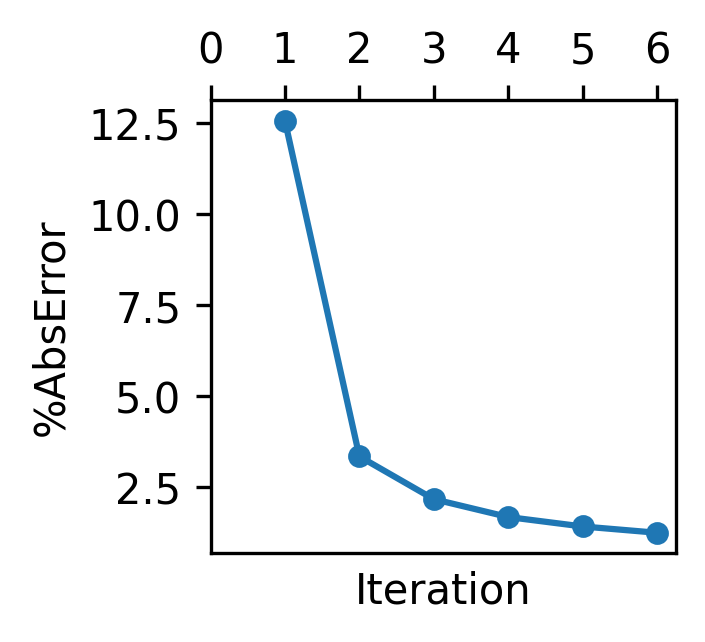

In [ ]:
def getKeyPoints(InvFile=InvFile):
  import csv
  global fileHeader 
  global iterationStartRowList
  global layerRowList 
  global layerDepths
  global noLayerRow
  global blockRow 
  global layerRow 
  global layerInfoRow 
  global resistDF
  global dataList
  global noPoints
  global calcResistivityRowList 
  global refResistRow
  global topoDataRow
  global iterationsInfoRow
  global iterationDF
  global noIterations
  global noDataPoints
  global shiftMatrixRow
  global electrodeCoordsRow
  global noTopoPts
  global sensAndUncertainRow
  global noModelBlocks
  global errorDistRow

  fileHeader = []
  iterationStartRowList = []
  layerRowList = []
  layerDepths = []
  noLayerRow = -1
  blockRow = -1
  layerRow = -1
  layerInfoRow = -1
  resistDF = pd.DataFrame()
  dataList = []
  noPoints = []
  calcResistivityRowList = []
  refResistRow=-1
  topoDataRow = -1
  iterationsInfoRow = -1

  with open(InvFile) as datafile: 
      filereader = csv.reader(datafile)
      for row in enumerate(filereader):
        startLayer = 0
        endLayer = 0
        lay = -1
        #print(row[0])
        if row[0] <= 8:
          if len(row[1])>1:
            fileHeader.append(row[1][0]+', '+row[1][1])
            continue
          else:
            fileHeader.append(row[1][0].strip())
            continue
        
        if 'NUMBER OF LAYERS' in str(row[1]):
          noLayerRow = row[0]+1
          continue
        if row[0] == noLayerRow:
          noLayers = int(row[1][0])
          layerList = np.linspace(1,noLayers, noLayers)
          continue
        
        if 'NUMBER OF BLOCKS' in str(row[1]):
          blockRow = row[0]+1
          continue
        if row[0]==blockRow:
          noBlocks = int(row[1][0])
          continue

        if 'ITERATION' in str(row[1]):
          iterationStartRowList.append(row[0]) #Add row of iteration to iterationStartRowList
          continue

        if 'LAYER ' in str(row[1]):
          iterInd = len(iterationStartRowList)-1
          if iterInd > len(layerRowList)-1:
            layerRowList.append([row[0]])
          else:
            layerRowList[iterInd].append(row[0])
          layerInfoRow = row[0]+1
          continue
        if row[0]==layerInfoRow:
          noPoints.append(int(row[1][0].strip()))
          layerDepths.append(row[1][1].strip())
          continue
        
        if 'CALCULATED APPARENT RESISTIVITY' in str(row[1]):
          calcResistivityRowList.append(row[0])
          continue
          
        if 'Reference resistivity is' in str(row[1]):
          refResistRow = row[0]+1 
          continue
        if row[0]==refResistRow:
          refResist = float(row[1][0].strip())
          continue
        
        if 'TOPOGRAPHICAL DATA' in str(row[1]):
          topoDataRow = row[0]
          continue
        if row[0]==topoDataRow+2:
          noTopoPts = int(row[1][0].strip())
          continue

        if 'COORDINATES FOR ELECTRODES' in str(row[1]):
          electrodeCoordsRow = row[0]
          continue

        if 'Shift matrix' in str(row[1]):
          shiftMatrixRow = row[0]
          continue

        if 'Blocks sensitivity and uncertainity values (with smoothness constrain)' in str(row[1]):
          sensAndUncertainRow = row[0]
          continue

        if 'Error Distribution' in str(row[1]):
          errorDistRow = row[0] #no of data points
          continue

        if 'Total Time' in str(row[1]):
          iterationsInfoRow=row[0]
          iterDataList = []
          continue
        
        if iterationsInfoRow > 1:
          if row[1] == []:
            print('   ')
            noIterations = row[0]-iterationsInfoRow-1
            break
          iterDataList.append(row[1][0].split())

  layerDepths = layerDepths[0:noLayers]
  layerDepths[noLayers-1] = float(layerDepths[(noLayers-2)])+(float(layerDepths[noLayers-2])-float(layerDepths[noLayers-3]))
  layerDepths = [float(x) for x in layerDepths]

  noPoints = noPoints[0:noLayers]

  keyList=['Name', 'NomElectrodeSpacing', 'ArrayCode', 'ProtocolCode', 'MeasureHeader', 'MeasureType', 'NoDataPoints','DistanceType','FinalFlag']

  global fileHeaderDict
  fileHeaderDict = dict(zip(keyList, fileHeader))
  noDataPoints = int(fileHeaderDict['NoDataPoints'])
  iterationDF = pd.DataFrame(iterDataList, columns=['Iteration',  'Time for this iteration', 'Total Time', '%AbsError'])
  iterationDF = iterationDF.apply(pd.to_numeric)

  print(iterationDF)
  fig1, ax1 = plt.subplots(1)
  iterationDF.plot('Iteration','%AbsError',figsize=(2,2), ax=ax1)
  iterationDF.plot('Iteration','%AbsError',figsize=(2,2),kind='scatter', ax=ax1)
  print(invFilePath.stem)
  ax1.set_xticks(np.arange(0,iterationDF['Iteration'].max()+1))
  ax1.get_legend().remove()
  plt.show(fig1)

getKeyPoints(InvFile)

## Select Iteration

In [1]:
def iterationDropfun():
  iterDropDown = widgets.Dropdown(options=list(np.linspace(1, noIterations, noIterations)),
                                  description='Iteration: ',
                                  disabled=False)

  iterationPrint = int(1)
  iterationInd = iterationPrint-1
  def iter_dropdown_handler(change):
      global iterationPrint
      global iterationInd
      global titleText
      print('iterationPrint '+str(change.new))
      iterationPrint = int(change.new)  
      iterationInd = iterationPrint-1
      titleText = invFilePath.stem +'\n Iteration: '+ str(iterationPrint) +' (' +str(round(iterationDF.loc[iterationInd,'%AbsError'],1))+'% Abs Error)'
  iterDropDown.observe(iter_dropdown_handler, names='value')
  display(iterDropDown)
  print('Default: Iteration 1')
  return iterationPrint, iterationInd
iterationPrint, iterationInd = iterationDropfun()

NameError: ignored

In [ ]:
#Dataframes to make

#Input Data
def readInputData(file=InvFile,noDataPoints=noDataPoints,startRow=9):
  import csv
  with open(InvFile) as datafile: 
      filereader = csv.reader(datafile)
      start = 0
      inDataList = []
      for row in enumerate(filereader):
        if row[0] < startRow:
          continue
        elif row[0] < startRow+noDataPoints:
          inDataList.append(re.sub('\s+',' ',row[1][0]).split(' '))
        else:
          break
  inDF = pd.DataFrame(inDataList)
  if startRow == 9:
    inDF.drop([0],inplace=True,axis=1)
  inDF.astype(np.float64)
  inDF.columns=['NoElectrodes', 'A(x)', 'A(z)', 'B(x)', 'B(z)', 'M(x)', 'M(z)', 'N(x)', 'N(z)', 'Data']
  return inDF

inputDF = readInputData(file=InvFile,noDataPoints=noDataPoints,startRow=9)
calcModelDF = readInputData(startRow=calcResistivityRowList[iterationInd]+1)

def readRestOfData(InvFile=InvFile, inputDF=inputDF, layerRowList=layerRowList, noPoints=noPoints,layerDepths=layerDepths,shiftMatrixRow=shiftMatrixRow,electrodeCoordsRow=electrodeCoordsRow,topoDataRow=topoDataRow,noTopoPts=noTopoPts,sensAndUncertainRow=sensAndUncertainRow):
  #Get Electrodes
  electrodes = inputDF['A(x)'].append(inputDF['B(x)'])
  electrodes = electrodes.append(inputDF['M(x)'])
  electrodes = electrodes.append(inputDF['N(x)'])
  electrodes = electrodes.unique()
  electrodes

  #ElectrodeCoordinates
  noModelElects = shiftMatrixRow-electrodeCoordsRow-1
  electrodeCoordsDF = pd.read_table(InvFile,skiprows=electrodeCoordsRow,nrows=noModelElects, sep='\s+')
  electrodeCoordsDF.dropna(axis=1,inplace=True)
  electrodeCoordsDF.columns=['xDist','RelElevation']
  electrodeCoordsDF['ElectrodeNo'] = electrodeCoordsDF.index+1
  electrodeCoordsDF

  #Topographical Data
  topoDF = pd.read_table(InvFile,skiprows=topoDataRow+2,nrows=noTopoPts, sep='\s+')
  topoDF.reset_index(inplace=True)
  topoDF.columns=['xDist','Elevation']
  topoDF['ElectrodeNo'] = topoDF.index+1
  topoDF

  #Resistivity Model
  resistModelDF = pd.DataFrame()
  for r in enumerate(layerRowList[iterationInd]):
    layerDepth = layerDepths[r[0]]
    noPtsInLyr = noPoints[r[0]]
    currDF = pd.read_table(InvFile,skiprows=r[1]+1, nrows=noPtsInLyr,sep=',')
    currDF.columns=['ElectrodeNo','Data']
    currDF['z'] = layerDepth
    resistModelDF= resistModelDF.append(currDF,ignore_index=True).copy()
  noModelBlocks=resistModelDF.shape[0]
  #resistModelDF.plot('x','z',kind='scatter',c='Data',vmin=0,vmax=100,ylim=[layerDepth,0])


  #Shift Matrix
  shiftMatrixDF = pd.read_table(InvFile,skiprows=shiftMatrixRow+1,nrows=noModelElects, sep='\s+',header=None,index_col=0)
  shiftMatrixDF.dropna(axis=1,inplace=True)
  for c in shiftMatrixDF:
    shiftMatrixDF.rename(columns={c:'Layer'+str(int(c)-1)},inplace=True)
  #shiftMatrixDF

  #Sensitivity
  sensDF = pd.read_table(InvFile,skiprows=sensAndUncertainRow+3,nrows=noModelBlocks, sep='\s+',header=None,index_col=0)
  sensDF.dropna(axis=1,inplace=True)
  sensDF.reset_index(inplace=True)
  sensDF.columns=['BlockNo','Sensitivity', '%ApproxUncertainty']
  #sensDF
  return electrodes, electrodeCoordsDF, topoDF, shiftMatrixDF, sensDF
electrodes, electrodeCoordsDF, topoDF, shiftMatrixDF, sensDF = readRestOfData()

#Error Distribution
def readErrorData(file=InvFile,noDataPoints=noDataPoints,startRow=errorDistRow+1):
  import csv
  with open(InvFile) as datafile: 
      filereader = csv.reader(datafile)
      start = 0
      inDataList = []
      for row in enumerate(filereader):
        if row[0] < startRow:
          continue
        elif row[0] < startRow+noDataPoints:
          newrow = row[1]
          newrow.append(newrow[4][8:])
          newrow[4] = newrow[4][0:8]
          newrow = [x.strip() for x in newrow]
          inDataList.append(newrow)
        else:
          break
  inDF = pd.DataFrame(inDataList)
  return inDF
errDistDF = readErrorData()

def avgErr(errDistDF=errDistDF):
  colList=['xDist?','nFactor?','Measure1','Measure2','PercentError','MoreStacks','AvgMeasure']
  for i in range(0,5):
    errDistDF[i]=errDistDF[i].astype(np.float64)
    errDistDF.rename(columns={i:colList[i]},inplace=True)
  errDistDF['AvgMeasure'] = (errDistDF['Measure1']+errDistDF['Measure2'])/2
  return errDistDF
errDistDf = avgErr()

def mapDiff(xIn, x1,x2,y1,y2):
    if x1==xIn:
        yOut=y1
    elif x2==xIn:
        yOut = y2
    else:
        totXDiff = x2-x1
        percXDiff = (xIn-x1)/totXDiff
        totYDiff = y2-y1
        yOut = y1 + totYDiff*percXDiff
    return yOut

## Now, go back through the file and make dataframes

### Main dataframe with resistivity results from selected iteration

In [ ]:
resistModelDF = pd.DataFrame()
def getResistivityModel(InvFile=InvFile,layerRowList=layerRowList,iterationInd=iterationInd,layerDepths=layerDepths,noPoints=noPoints, electrodeCoordsDF=electrodeCoordsDF, resistModelDF=resistModelDF):
  #global electrodeCoordsDF
  global topoDF

  for r in enumerate(layerRowList[iterationInd]):
    layerDepth = layerDepths[r[0]]
    noPtsInLyr = noPoints[r[0]]
    currDF = pd.read_table(InvFile,skiprows=r[1]+1, nrows=noPtsInLyr,sep=',')
    currDF.iloc[currDF.shape[0]-1,1] =  currDF.iloc[currDF.shape[0]-1,0]
    currDF.iloc[currDF.shape[0]-1,0] = currDF.iloc[currDF.shape[0]-2,0]+1
    currDF.columns=['ElectrodeNo','Data']
    currDF['zDepth'] = layerDepth

    for i in currDF.index:
      lowerElecNo = currDF.loc[i,'ElectrodeNo']#-1
      elecInd = electrodeCoordsDF.loc[electrodeCoordsDF['ElectrodeNo']==lowerElecNo].index.values[0]
      currDF.loc[i,'x'] = (electrodeCoordsDF.loc[elecInd,'xDist'] + electrodeCoordsDF.loc[elecInd+1,'xDist'])/2
      for xT in enumerate(topoDF['xDist']):
        if xT[1] < currDF.loc[i,'x']:
          continue
        else:
          topoX1 = topoDF.loc[xT[0]-1,'xDist']
          topoX2 = topoDF.loc[xT[0],'xDist']
          topoZ1 = topoDF.loc[xT[0]-1,'Elevation']
          topoZ2 = topoDF.loc[xT[0],'Elevation']
        break
      currDF.loc[i,'zElev'] = mapDiff(currDF.loc[i,'x'],topoX1, topoX2, topoZ1, topoZ2)-currDF.loc[i,'zDepth']
    if r[0] == 0:
      surfDF = currDF.copy()
      surfDF['zElev'] = surfDF.loc[:,'zElev']+surfDF.loc[:,'zDepth']
      surfDF['zDepth'] = 0
      resistModelDF= resistModelDF.append(surfDF,ignore_index=True).copy()
    resistModelDF= resistModelDF.append(currDF,ignore_index=True).copy()
  #noModelBlocks=resistModelDF.shape[0]
  return resistModelDF

resistModelDF = getResistivityModel()

## Create functions used to plot data

### Plotting function

In [ ]:
def plotPretty(x,z,v,im,cbarTicks,fig,ax,colMap='jet',cMin=resistModelDF['Data'].min(),cMax=resistModelDF['Data'].max(), gridFt=[False,False], gridM=[False,False], t=titleText, primaryUnit='m', cBarFormat ='%3.0f',cBarLabel ='Resistivity (ohm-m)', showPoints=False, norm=0, whichTicks='major', reverse=False):
  plt.rcParams["figure.dpi"] = 300  
  plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
  plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = plt.rcParams["xtick.top"] = True
  plt.sca(ax)
 

  vmax90 = np.percentile(v, 90)
  vmin2 = np.percentile(v, 2)
  vmax = v.max()
  vmin = v.min()
  minx = topoDF['xDist'].min()
  maxx = topoDF['xDist'].max()
  minz = min(z)
  maxz = max(z)

  #xlocsM = ax.get_xticks()
  if maxx>800:
    xlocsM = np.arange(minx,maxx+1,100)
    if max(xlocsM) < maxx:
      xlocsM = np.arange(minx,maxx+101,100)
  else:
    xlocsM = np.arange(minx,maxx+1,50)
    if max(xlocsM) < maxx:
      xlocsM = np.arange(minx,maxx+51,50)

  xlabelsM = [str(int(x)) for x in xlocsM]
  xlocsFt = np.uint16(xlocsM*3.2808399)
  xlabelsFt = [str(int(x)) for x in xlocsFt]


  minFtxLoc = xlocsFt[0]
  maxFtxLoc = xlocsFt[-1]
  xLabelsFtEven = np.arange(np.round(minFtxLoc,-1), np.round(maxFtxLoc,-1), 100)

  if np.round(maxFtxLoc,-1) < maxFtxLoc:
    xLabelsFtEven=np.insert(xLabelsFtEven, len(xLabelsFtEven),np.round(maxFtxLoc,-2))
    xLabelsFtEven=np.insert(xLabelsFtEven, len(xLabelsFtEven),np.round(maxFtxLoc,-2)+100)
  xLocs_FTinM = xLabelsFtEven / 3.2808399

  if np.ceil(maxz)>np.round(maxz,-1):
    zEnd = np.round(maxz,-1)+11
  else:
    zEnd = np.round(maxz,-1)+1
  
  ylocsM = np.arange(np.round(minz,-1),zEnd,10)
  ylabelsM = [str(x) for x in ylocsM]
  yLabelsFt = np.uint16(ylocsM*3.2808399)

  minFtyLabel = yLabelsFt.min()
  maxFtyLabel = yLabelsFt.max()
  yLabelsFtEven = np.arange(0, np.round(maxFtyLabel,-1), 20)
  

  if np.round(maxFtyLabel,-1) < maxFtyLabel:
    yLabelsFtEven=np.insert(yLabelsFtEven, len(yLabelsFtEven),yLabelsFtEven[-1]+20)
  yLocs_FTinM = yLabelsFtEven / 3.2808399

  yLimsM = [ylocsM[1],maxz+3]
  yLimsFt = [np.round(yLimsM[0]*3.2808399, 0), np.round(yLimsM[1]*3.2808399, 0)]

  ax.fill_between(topoDF['xDist'],topoDF['Elevation'],topoDF['Elevation']+10,color='w')
  ax.plot(topoDF['xDist'],topoDF['Elevation'],color='k',linewidth=1)
  ax.scatter(topoDF['xDist'],topoDF['Elevation'],marker='v',edgecolors='w',color='k',s=30)
  if showPoints:
    plt.scatter(x,z, c=v, marker='.', cmap='nipy_spectral', norm=norm)

  xLimsM = [minx,maxx]
  xLimsFt = [np.round(xLimsM[0]*3.2808399, 0), np.round(xLimsM[1]*3.2808399, 0)]
  if reverse:
    xLimsM.reverse()
    xLimsFt.reverse()
    #xlocsM=np.flip(xlocsM)
    #xLocs_FTinM=np.flip(xLocs_FTinM)

  def labelPlot(pUnit, pUnitXLocs, pUnitYLocs, pUnitXLabels,pUnitYLabels, sUnit, sUnitXLocs, sUnitYLocs, sUnitXLabels, sUnitYLabels, xLims=xLimsM, yLims=yLimsM, t=t):
      #matplotlib.rc('font', family='sans-serif')   
      #matplotlib.rc('font', serif='Helvetica') 
      #matplotlib.rc('text', usetex='false')   
      #fontName = {'fontname':'Helvetica'}
      
      #plt.title(t,**fontName)
      ax.set_title(t, fontsize=20)
      ax.set_xlabel('Distance ['+sUnit+']', fontsize = 12)
      ax.set_ylabel('Elevation ['+pUnit+']', fontsize = 14)
      ax.set_xticks(sUnitXLocs)
      ax.set_yticks(pUnitYLocs)
      ax.set_xticklabels(sUnitXLabels,fontsize=12)
      ax.set_yticklabels(pUnitYLabels,fontsize=12)
      ax.set_yticks(pUnitYLocs)
      ax.set_ylim(yLims)
      ax.set_xlim(xLims)
      ax.minorticks_on()

      ax2=ax.twiny()
      ax2.set_xticks(pUnitXLocs)
      ax2.set_xticklabels(pUnitXLabels,fontdict={'fontsize':14})
      ax2.set_xlabel('Distance ['+pUnit+']',fontsize=14)
      ax2.minorticks_on()
      ax2.set_xlim(xLimsM)

      ax3=ax2.twinx()
      ax3.set_yticks(sUnitYLocs)
      ax3.set_yticklabels(sUnitYLabels,fontdict={'fontsize':10})
      ax3.set_ylim(yLims)
      ax3.set_ylabel('Elevation ['+sUnit+']',fontsize=14, rotation=270, labelpad = 20)
      ax3.minorticks_on()
     

      if pUnit=='m':
        if gridM[0]:
          ax2.grid(axis='x',alpha=0.5, c='k', which=whichTicks)
        if gridM[1]:
          ax.grid(axis='y',alpha=0.5, c='k', which=whichTicks)
        if gridFt[0]:
          ax.grid(axis='x',alpha=0.5, c='k', which=whichTicks)
        if gridFt[1]:
          ax3.grid(axis='y',alpha=0.5, c='k', which=whichTicks)
      else:
        if gridFt[0]:
          ax2.grid(axis='x',alpha=0.5, c='k', which=whichTicks)
        if gridFt[1]:
          ax.grid(axis='y',alpha=0.5, c='k', which=whichTicks)
        if gridM[0]:
          ax.grid(axis='x',alpha=0.5, c='k', which=whichTicks)
        if gridM[1]:
          ax3.grid(axis='y',alpha=0.5, c='k', which=whichTicks)

  if primaryUnit in ['m', 'meters', 'meter', 'metres', 'metre', 'metric']:
    pUnit = 'm'
    pUnitXLocs = xlocsM
    pUnitYLocs = ylocsM
    pUnitXLabels = xlabelsM
    pUnitYLabels = ylabelsM

    sUnit = 'ft'
    sUnitXLocs = xLocs_FTinM
    sUnitYLocs = yLocs_FTinM
    sUnitXLabels = xLabelsFtEven
    sUnitYLabels = yLabelsFtEven
    labelPlot(primaryUnit, pUnitXLocs, pUnitYLocs, pUnitXLabels,pUnitYLabels, sUnit, sUnitXLocs, sUnitYLocs, sUnitXLabels, sUnitYLabels)
  
  elif primaryUnit in ['f', 'ft', 'feet', 'foot', 'US']:
    pUnit = 'ft'
    pUnitXLocs = xLocs_FTinM
    pUnitYLocs = yLocs_FTinM
    pUnitXLabels = xLabelsFtEven
    pUnitYLabels = yLabelsFtEven
    
    sUnit = 'm'
    sUnitXLocs = xlocsM
    sUnitYLocs = ylocsM
    sUnitXLabels = xlabelsM
    sUnitYLabels = ylabelsM
    labelPlot(primaryUnit, pUnitXLocs, pUnitYLocs, pUnitXLabels,pUnitYLabels, sUnit, sUnitXLocs, sUnitYLocs, sUnitXLabels, sUnitYLabels)  
  
  else:
    pUnit = 'm'
    pUnitXLocs = xlocsM
    pUnitYLocs = ylocsM
    pUnitXLabels = xlabelsM
    pUnitYLabels = ylabelsM

    sUnit = 'ft'
    sUnitXLocs = xLocs_FTinM
    sUnitYLocs = yLocs_FTinM
    sUnitXLabels = xLabelsFtEven
    sUnitYLabels = yLabelsFtEven
    labelPlot(primaryUnit, pUnitXLocs, pUnitYLocs, pUnitXLabels,pUnitYLabels, sUnit, sUnitXLocs, sUnitYLocs, sUnitXLabels, sUnitYLabels)

  cbar = fig.colorbar(im, ax=ax,orientation='horizontal', aspect=50, extend='both',ticks=cbarTicks,format=cBarFormat)
  cbar.ax.tick_params(labelsize=16)#set_ticks(cbarTicks)
  cbar.set_label(label=cBarLabel, size=20)

  ax_h, ax_w = ax.bbox.height, ax.bbox.width
  axRatio = ax_w/ax_h
  aspRatio = (xLimsM[1]-xLimsM[0])/(yLimsM[1]-yLimsM[0])
  vertExag = abs(round(aspRatio/axRatio, 1))
  ax.annotate('Vert.Exag: '+str(vertExag)+'x',xy=(0.95,0.05),xycoords='axes fraction')
  #fig.tight_layout()
  fig.set_facecolor("w")

  plt.show(fig)
  return fig, ax
  #fig.tight_layout()

  

### Function to interpolate and grid resistivity data

In [ ]:
maxXDist = max(np.float_(electrodes))

def makeColormesh(x,z,v,colMap='nipy_spectral', cBarFormat ='%3.0f', cBarLabel ='Resistivity (ohm-m)', cMin=resistModelDF['Data'].min(),cMax=resistModelDF['Data'].max(), griddedFt=[False,False], griddedM=[False,False], title=invFilePath.stem,normType='linear', primaryUnit='m', showPoints=False,whichTicks='major', reverse=False):#, pe,xOmit,zOmit):
  for i in enumerate(v):
      v[i[0]] = abs(float(i[1]))

  #v=v[(v<=cMax)&(v>=cMin)].copy()
  #indVals = v.index.copy()
  #v.reset_index(drop=True,inplace=True)
  #print(x)
  #print(indVals)
  #print(z)

  #x=x[indVals].reset_index(drop=True,inplace=True)
  #z=z[indVals].reset_index(drop=True,inplace=True)

  xi, zi = np.linspace(min(x), max(x), int(max(x))), np.linspace(min(z), max(z), int(max(z)))
  xi, zi = np.meshgrid(xi, zi)

  vi = scipy.interpolate.griddata((x, z), v, (xi, zi))#, method='linear')

  ptSize = round(100 / maxXDist * 35, 1)

  fig, axes = plt.subplots(1)
  cmap = matplotlib.cm.binary
  my_cmap = cmap(np.arange(cmap.N))
  my_cmap[:,-1] = np.linspace(0,1,cmap.N)
  my_cmap = matplotlib.colors.ListedColormap(my_cmap)

  vmax98 = np.percentile(v, 98)
  vmin2 = np.percentile(v, 2)
  minx = min(x)
  maxx = max(x)
  minz = min(z)
  maxz = max(z)

  vmax = cMax
  vmin = cMin

  #if cMax >= resistModelDF['Data'].max():
  #  vmax = vmax98
  #else:
  #  vmax = cMax
  #if cMin <= resistModelDF['Data'].min():
  #  vmin = vmin2
  #else:
  #  vmin = cMin
  #cbarTicks = np.arange(np.round(vmin,-1),np.round(vmax-1)+1,10) 

  if normType=='log':
    if vmin <= 0:
      vmin = 0.1
    norm = matplotlib.colors.LogNorm(vmin = vmin, vmax = vmax)
    #cBarFormat = '%.1e'
    #cbarTicks = np.logspace(np.log10(vmin),np.log10(vmax),num=10)
  else:
    norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
  
  arStep = np.round((vmax-vmin)/10,-1)

  cbarTicks = np.arange(np.round(vmin, -1), np.ceil(vmax/10)*10,arStep)


  #im = self.axes.imshow(vi, vmin=vmin, vmax=vmax, origin='lower',
  im = axes.imshow(vi, origin='lower',
              extent=[minx, maxx, minz, maxz],
              aspect='auto',
              cmap=colMap,
              norm = norm,
              interpolation='spline36')

  
  f, a = plotPretty(x,z,v,fig=fig,im=im,ax=axes,colMap=colMap,cMin=cMin,cMax=cMax, gridM=griddedM, gridFt=griddedFt, primaryUnit=primaryUnit,cbarTicks=cbarTicks,cBarFormat=cBarFormat,showPoints=showPoints, norm=norm, whichTicks=whichTicks, reverse=reverse)

  plt.close(f)
  return f, a

# Plot the data

## Plot the resistivity data for the selected inversion

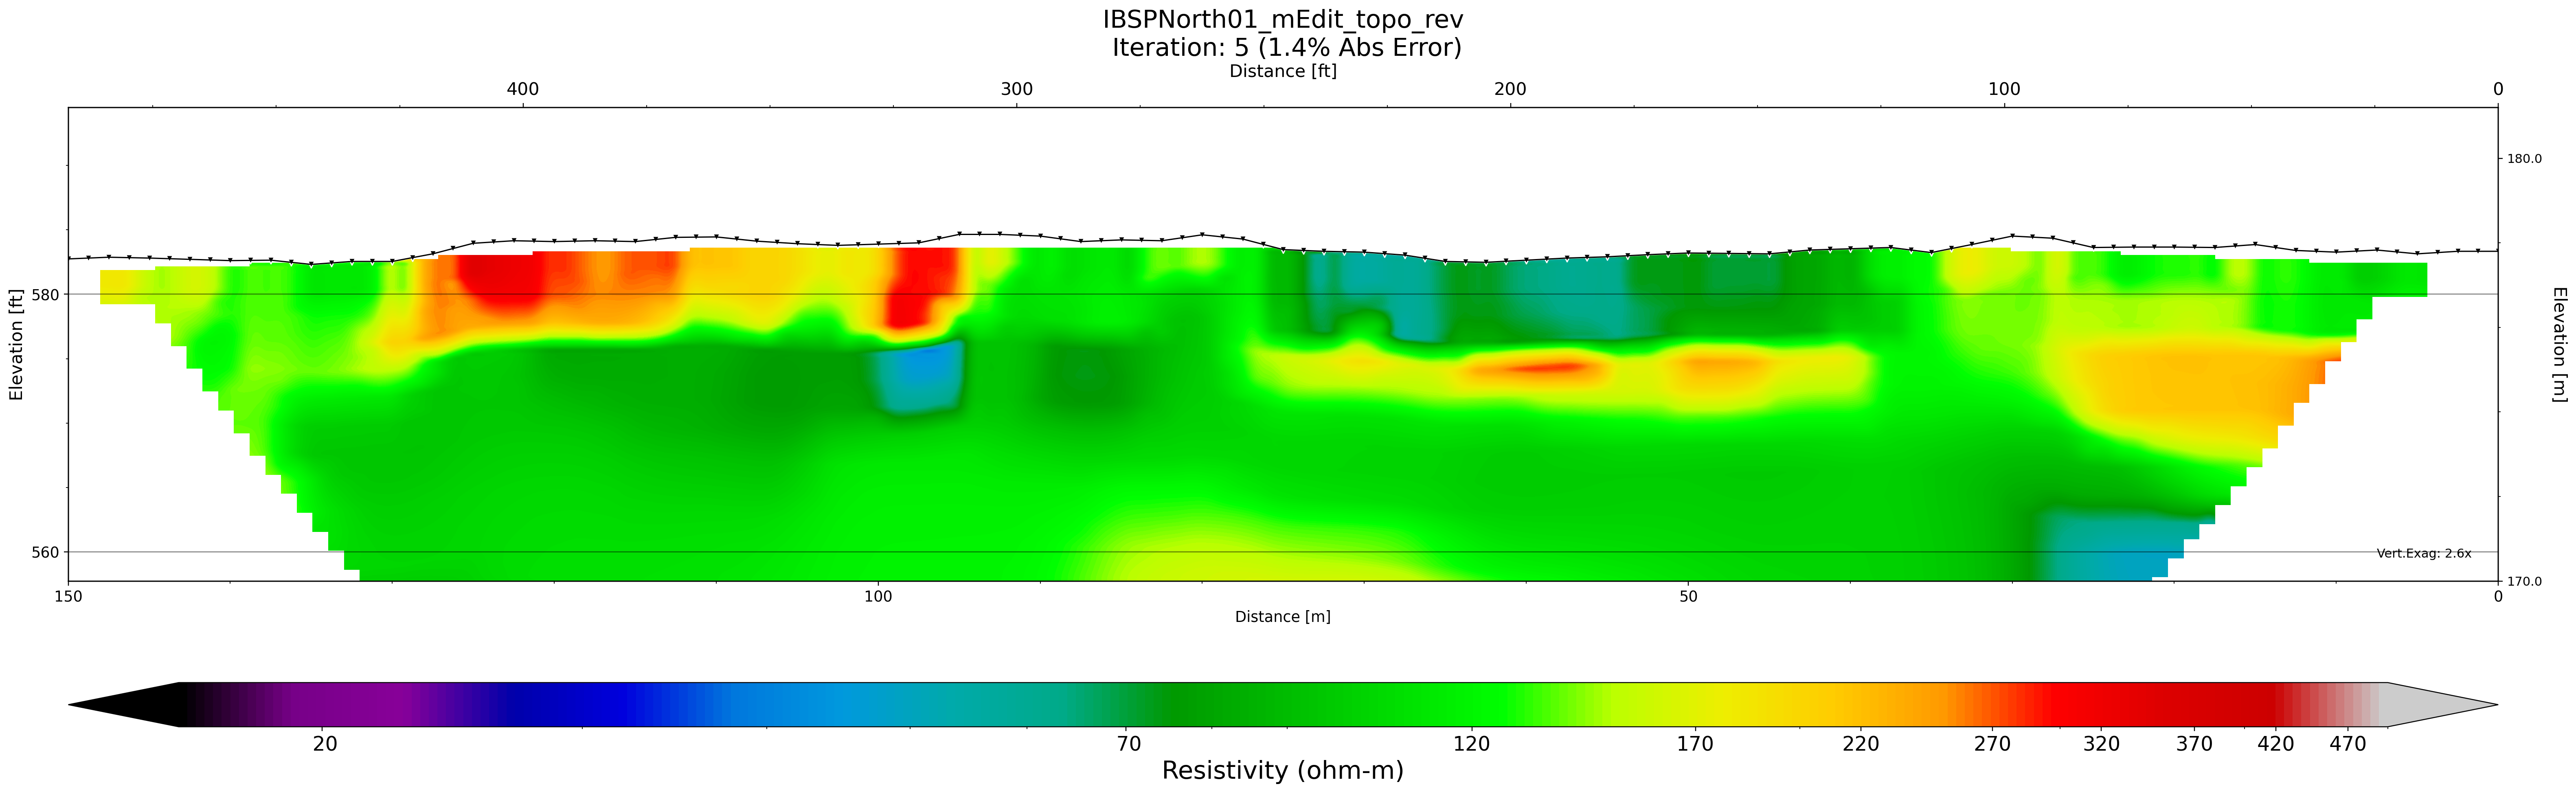

In [ ]:
x = resistModelDF['x'].copy()
z = resistModelDF['zElev'].copy()
v = resistModelDF['Data'].copy()
plt.rcParams['figure.dpi'] = 220
plt.rcParams['figure.figsize'] = (35,10)

[figure, axis] = makeColormesh(x,z,v,colMap='nipy_spectral', griddedM=[False,False],griddedFt=[False,True],normType='log', primaryUnit='ft', cMin=16,cMax=500,showPoints=False, whichTicks='major', reverse=True)

In [ ]:
invFileDropFun()

   
   Iteration  Time for this iteration  Total Time  %AbsError
0          1                   116.28      116.28     12.444
1          2                    51.02      167.30      5.639
2          3                    67.89      235.19      4.913
3          4                    68.58      303.77      4.688
RandallRd_pyEdit_topo


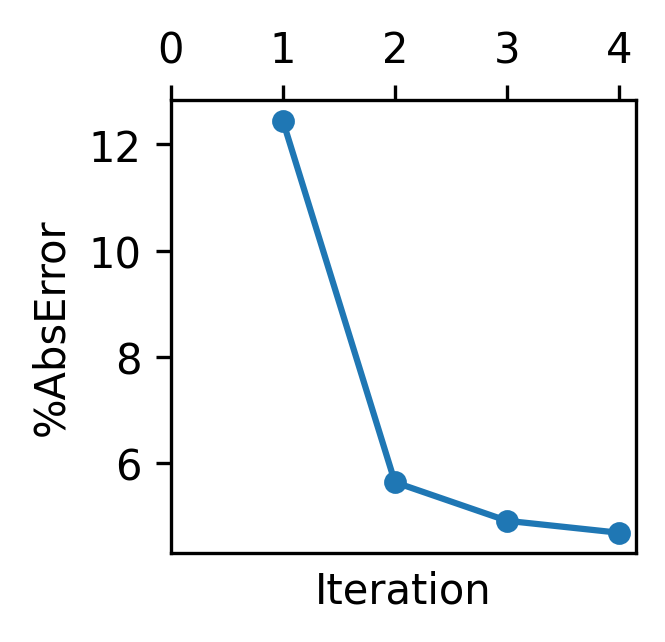

Dropdown(description='Iteration: ', options=(1.0, 2.0, 3.0, 4.0), value=1.0)

Default: Iteration 1
iterationPrint 3.0


In [ ]:
getKeyPoints(InvFile)
iterationPrint, iterationInd = iterationDropfun()

In [ ]:
inputDF = readInputData(file=InvFile,noDataPoints=noDataPoints,startRow=9)
calcModelDF = readInputData(file=InvFile,noDataPoints=noDataPoints,startRow=calcResistivityRowList[iterationInd]+1)

electrodes, electrodeCoordsDF, topoDF, shiftMatrixDF, sensDF = readRestOfData()
errDistDF = readErrorData()
errDistDF = avgErr()

resistModelDF = pd.DataFrame()
resistModelDF = getResistivityModel()

KeyError: ignored

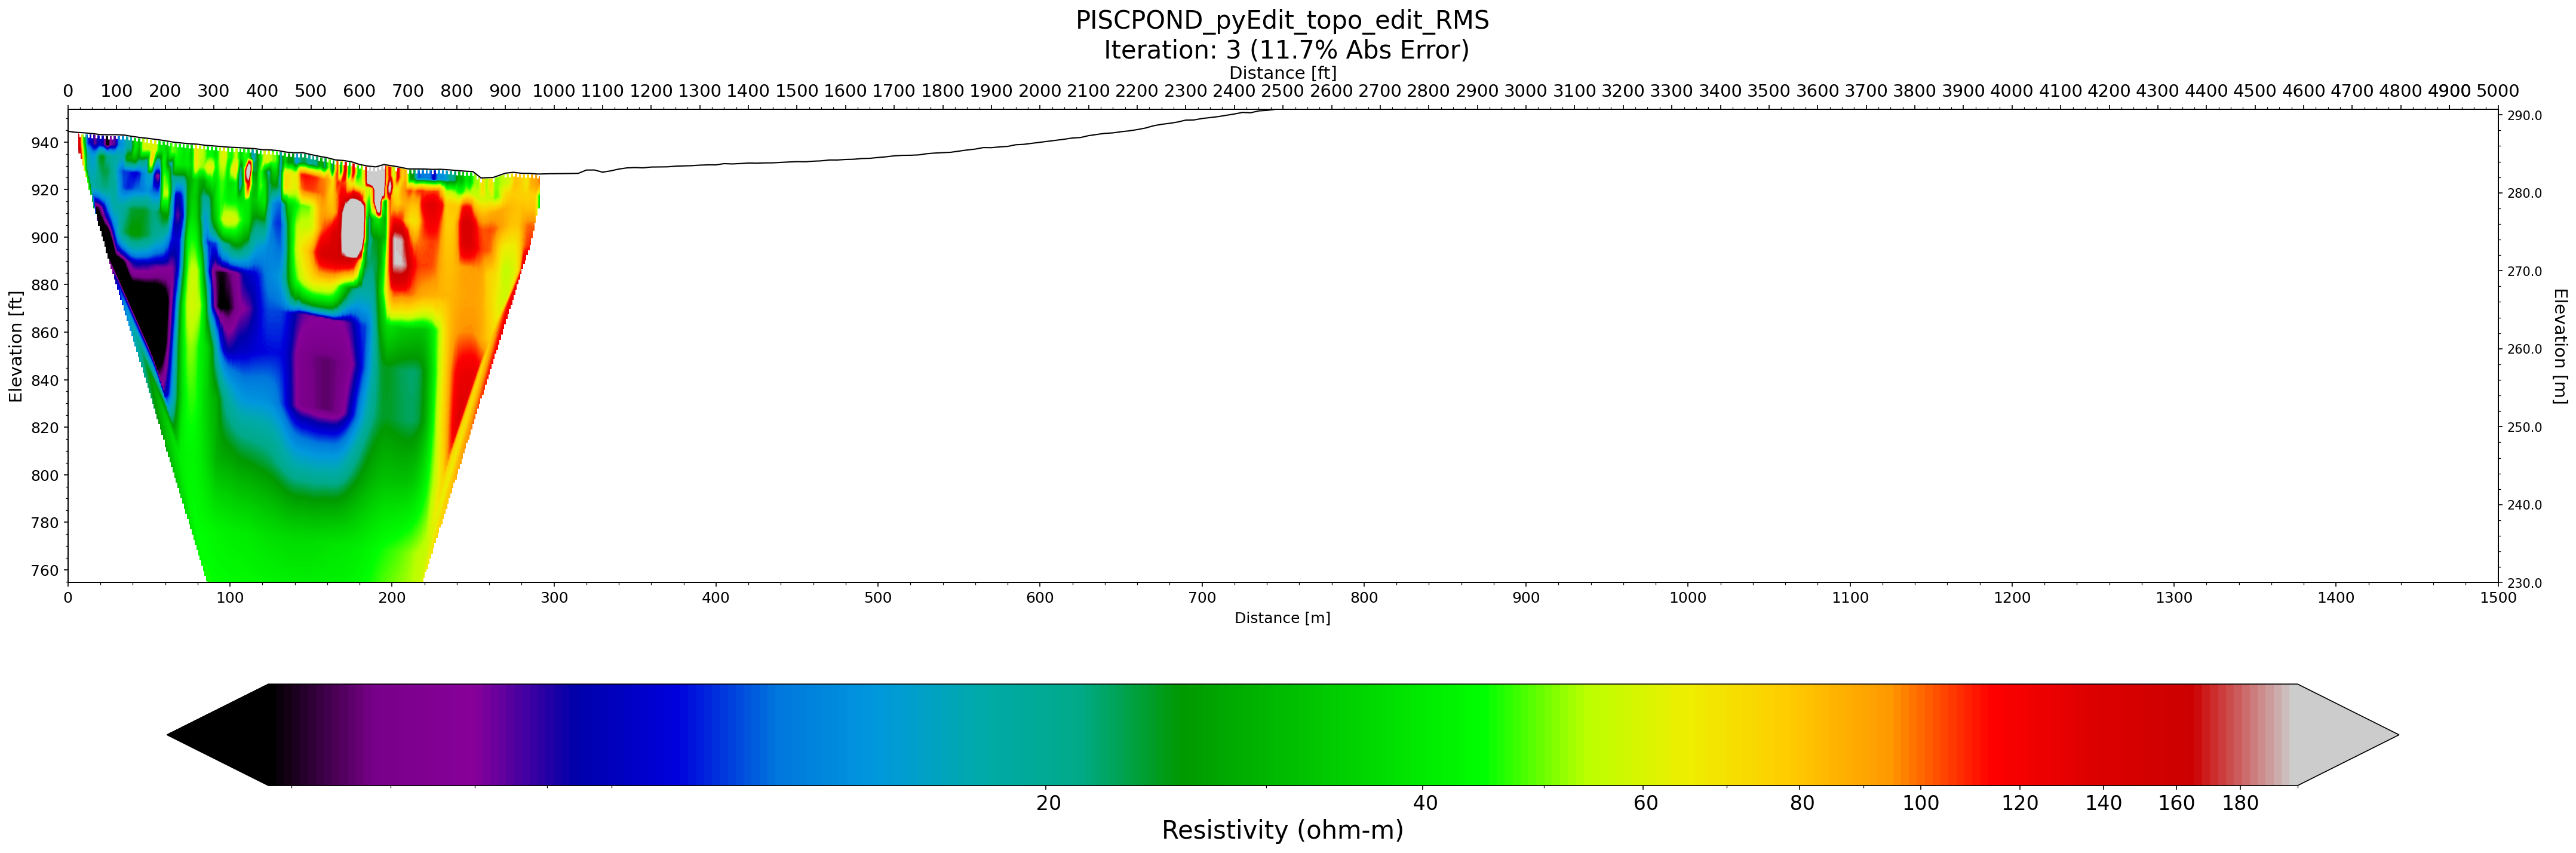

In [ ]:
x = resistModelDF['x'].copy()
z = resistModelDF['zElev'].copy()
v = resistModelDF['Data'].copy()
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (35,10)

[figure, axis] = makeColormesh(x,z,v,colMap='nipy_spectral', griddedM=[False,False],griddedFt=[False,False],normType='log', primaryUnit='ft', cMin=0,cMax=200)

In [ ]:
OGresistModelDF = resistModelDF.iloc[sensDF.shape[0]*-1:,:].copy().reset_index(drop=True)
sensDF_wXYZ=sensDF.merge(OGresistModelDF, left_index=True,right_index=True)
sensDF_wXYZ

,BlockNo,Sensitivity,%ApproxUncertainty,ElectrodeNo,Data,zDepth,x,zElev
0,1,2.4705,1.62,4.0,71.089,1.25000,6.243735,258.850150
1,2,2.3257,1.62,5.0,69.261,1.25000,8.742871,258.790171
2,3,2.1170,2.05,6.0,76.042,1.25000,11.241888,258.799740
3,4,2.0580,1.87,7.0,75.537,1.25000,13.740784,258.879705
4,5,2.0637,2.06,8.0,76.262,1.25000,16.240220,258.917520
...,...,...,...,...,...,...,...,...
7683,7684,0.0860,3.33,507.0,95.611,87.36909,1263.045654,174.833093
7684,7685,0.0865,3.30,508.0,93.216,87.36909,1265.545654,174.842001
7685,7686,0.0870,3.25,509.0,91.091,87.36909,1268.045654,174.847001
7686,7687,0.0872,3.13,510.0,89.321,87.36909,1270.545654,174.854184


In [ ]:
x = sensDF_wXYZ['x'].copy()
z = sensDF_wXYZ['zElev'].copy()
v = sensDF_wXYZ['Sensitivity'].copy()
#plt.rcParams['figure.dpi'] = 300 

[figure, axis] = makeColormesh(x,z,v, title='Sensitivity: County Road 500E',colMap='nipy_spectral', griddedM=[False,False],griddedFt=[False,False],normType='lin', primaryUnit='ft',cBarLabel='Sensistivity',cBarFormat='%.2f')

Output hidden; open in https://colab.research.google.com to view.